<div dir="rtl">
    <font size="4"><b>پروژه چهارم - یادگیری ماشین</b></font>
    <font size="3"><br>هدف پروژه : در این پروژه هدف تخمین قیمت خودروها در آگهی های سایت دیوار است. میخواهیم به کمک کتابخانه scikit learn و مدلهای پیاده سازی شده در آن، سعی کنیم برای هر مدل هایپرپارامترها را بهینه کنیم و در نهایت نتایج مدلها را باهم مقایسه کنیم.<br>مجموعه داده: تعدادی آگهی فروش خودرو در سایت دیوار در فرمت csv در اختیار داریم. در این داده، عنوان آگهی، توضیحات مربوط به خودرو، نوع خودرو، زمان درج آگهی، تعداد تصاویر بارگذاری شده در کنار آگهی، کارکرد خودرو و سال تولید آن مشخص شده است. در نهایت یک ستون قیمت خودرو وجود دارد که همان مدل هدف خواهد بود.</font>
</div>

<div dir="rtl">
    <font size="4"><b>فاز اول: پیش پردازش و مشاهده داده ها</b></font>
    <font size="3"><br></font>

In [1]:
pip install hazm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
datum = pd.read_csv("vehicles.csv")

<div dir="rtl">
    <font size="3">حذف مقادیر خالی در ستون brand و مقادیر -1 در ستون price:</font>
</div>

In [3]:
def drop_nan(datum):
    datum = datum.dropna(subset=['brand'])
    datum = datum[datum.price != -1]
    return datum

<div dir="rtl">
    <font size="3">encode کردن داده های ستون brand و category بصورت label:</font>
</div>

In [4]:
from sklearn import preprocessing

def encoding(datum):
    le = preprocessing.LabelEncoder()
    datum['category'] = le.fit_transform(datum['category'])
    datum['brand'] = le.fit_transform(datum['brand'])
    return datum

<div dir="rtl">
    <font size="3">Normalize کردن ستون title و description:</font>
</div>

In [5]:
from hazm import *

def normalize(datum):
    normalizer = Normalizer()
    datum['text'] = datum['description'] + ' ' + datum['title']
    datum['text'] = datum['text'].apply(lambda x: normalizer.normalize(x))
    
def tokenize(datum):
    datum['text'] = datum['text'].apply(lambda x: word_tokenize(x))
    
def stemming(datum):
    stemmer = Stemmer()
    datum['text'] = datum['text'].apply(lambda x: [stemmer.stem(i) for i in x])
    
def remove_stop_words(datum):
    signs = ['»','«','@','#','$','%','(',')','*','-','_','>','<','=','+','،','.','?','؟','!',':','؛']
    stopwordslist = stopwords_list()
    stopwordslist = stopwordslist + signs
    stopwords = set(stopwordslist)
    datum['text'] = datum['text'].apply(lambda x: [i for i in x if i not in stopwords])

<div dir="rtl">
    <font size="3">تبدیل کردن مقادیر ستون year و created_at به عدد صحیح و اجرای عملیات tf_idf و countvectorizer برروی ستونهای title و description:</font>
</div>

In [6]:
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def year_to_int(datum):
    datum['year'] = datum['year'].str.extract('(\d+)', expand=False)
    datum['year'] = datum['year'].astype(int)

def datetime_to_int(datum):
    week_days = {'Saturday': 0, 'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6}
    created_at = list(datum['created_at'])
    for i in range(len(created_at)):
        day = created_at[i].split(' ')[0]
        dt = datetime.strptime(created_at[i], '%A %I%p')
        created_at[i] = (week_days[day]*24) + dt.hour
    datum['created_at'] = created_at
    
def tf_idf(datum):
    datum['text'] = datum['text'].apply(lambda x: " ".join(x))
    
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=200)  
    vectorized = vectorizer.fit_transform(list(datum['text']))
    df = pd.DataFrame(vectorized.toarray(), index=[int(i) for i in range(1, 1+len(datum))], columns=vectorizer.get_feature_names())
    datum = datum.drop(['description', 'title', 'text'],axis=1)
    datum[vectorizer.get_feature_names()] = df[vectorizer.get_feature_names()].values

    return datum

def count_vectorizer(datum):
    datum['text'] = datum['text'].apply(lambda x: " ".join(x))
    
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=200)  
    vectorized = vectorizer.fit_transform(list(datum['text']))
    df = pd.DataFrame(vectorized.toarray(), index=[int(i) for i in range(1, 1+len(datum))], columns=vectorizer.get_feature_names())
    datum = datum.drop(['description', 'title', 'text'],axis=1)
    datum[vectorizer.get_feature_names()] = df[vectorizer.get_feature_names()].values
    
    return datum

<div dir="rtl">
    <font size="3">محاسبه information gain ستونهای brand, category, created_at, image_caount, mileage و year:</font>
</div>

In [7]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression

def information_gain(datum):
    X = datum[['brand', 'category', 'created_at', 'image_count', 'mileage', 'year']]
    target = datum['price']
    mi = mutual_info_regression(X, target)
    mi = pd.Series(mi)
    mi.index = X.columns
    mi.sort_values(ascending=False, inplace = True)
    return mi

<div dir="rtl">
    <font size="3">رسم نمودار gainهای محاسبه شده ستونها بر حسب ستون قیمت:</font>
</div>

In [8]:
import matplotlib.pyplot as plt

def gain_diagram(mi):
    plt.title('Mutual information with respect to features')
    mi.plot.bar()
    plt.show()

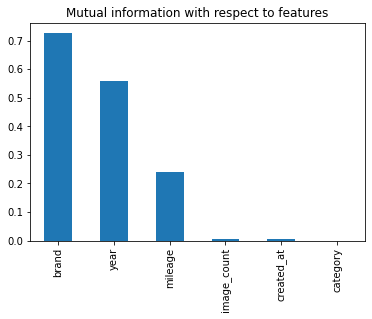

In [9]:
datum = drop_nan(datum)
year_to_int(datum)
datetime_to_int(datum)
datum = encoding(datum)
normalize(datum)
tokenize(datum)
stemming(datum)
remove_stop_words(datum)
#datum = tf_idf(datum)
datum = count_vectorizer(datum)
mi = information_gain(datum)
gain_diagram(mi)

<div dir="rtl">
    <font size="3">1) این نمودار میزان همبستگی و رابطه فیچرهای موردنظر با ویژگی هدف را مشخص میکند و به کمک این نمودار میتوان ویژگیهایی را که همبستگی بیشتری با ستون هدف دارند (دارای مقادیر IG بیشتری هستند) شناسایی کرد و از آنها برای ساخت مدل استفاده کرد.<br><br>
    2) برای ستون brand و category که داده های به شکل دسته بندی هستند از روش label encoding استفاده میکنیم تا داده های به شکل قابل پردازش برای مدلهای یادگیری ماشین تبدیل شوند. دلیل انتخاب روش label encoding این است که برخلاف روش دیگر ستون جدیدی به دیتافریم اضافه نیمکند و حجم دیتا پردازشی افزایش پیدا نمیکند.<br><br>
    3) تغییر تعداد کلمات تاثیر چندانی در بهتر کردن مدلسازی ها نداشت. استفاده از countvectorizer در مقایسه با tf_idf به مقدار کمی باعث بهتری شدن نتیجه مدل RandomForest شد.<br><br>
    4) یکی از روشها حذف سطرهای مربوط به داده های از دست رفته است و روش دیگر جایگزین کردن مقدار از دست رفته با میانگین یا میانه داده های آن ستون است. ما در آماده سازی داده برای مسئله، روش اول را انتخاب کرده ایم.
    </font>
</div>

<div dir="rtl">
    <font size="4"><b>فاز دوم: پیشبینی قیمت</b></font>
    <font size="3"><br></font>

<div dir="rtl">
    <font size="3">تقسیم داده ها به دو قسمت train و test با نسبت p:</font>
</div>

In [10]:
from sklearn.model_selection import train_test_split

def split_data(datum, p):
    train, test = train_test_split(datum, test_size=p)
    y_train = train['price']
    x_train = train.drop(['price'], axis=1)
    y_test = test['price']
    x_test = test.drop(['price'], axis=1)
    return x_train, y_train, x_test, y_test

<div dir="rtl">
    <font size="3">محاسبه مقادیر mse و rmse:</font>
</div>

In [11]:
from sklearn.metrics import mean_squared_error as MSE
import math

def evaluate(y_test, y_predicted):
    mse = MSE(y_test, y_predicted)
    rmse = math.sqrt(mse)
    return mse, rmse

<div dir="rtl">
    <font size="3">مدل KNN با مقدار هاپرپارامتر k:</font>
</div>

In [12]:
from sklearn.neighbors import KNeighborsRegressor

def KNN(datum, k, p):
    model = KNeighborsRegressor(n_neighbors=k)
    x_train, y_train, x_test, y_test = split_data(datum, p)
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    return y_predicted, y_test

<div dir="rtl">
    <font size="3">مدل DecisionTree با مقادیر هایپرپارامتر d و s:</font>
</div>

In [33]:
from sklearn.tree import DecisionTreeRegressor

def Decision_Tree(x_train, y_train, x_test, s, d):
    model = DecisionTreeRegressor(max_depth=d, min_samples_split=s) 
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    return y_predicted

<div dir="rtl">
    <font size="3">مدل linear Regression:</font>
</div>

In [14]:
from sklearn.linear_model import LinearRegression

def Linear_Regression(datum, p):
    model = LinearRegression()
    x_train, y_train, x_test, y_test = split_data(datum, p)
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    return y_predicted, y_test

<div dir="rtl">
    <font size="3">5) زمانیکه نسبت برابر 98 به 2 است خطای مدل کمتر میشود (نسبت به حالتی که ما p را در تابع split_data برابر با 0.1 درنظر گرفتیم). هنگامی که سهم دادهای آموزش کاهش میابد، مدل جامعیت خود را از دست میدهد و و احتمال overfitting بیشتر میشود. overfitting به این معناست که مدل با داده های train به خوبی کار میکند ولی برای برای داده های جدید قابل اعتماد نیست. حال اگر سهم داده های تست را خیلی کم و سهم داده های آموزش را خیلی زیاد کنیم آنگاه بدلیل اینکه داده های کمی برای ارزیابی مدل داریم نمیتوان مدل را بدرستی ارزیابی کرد و ممکن است underfitting رخ دهد. underfitting به این معناست که بدلیل یادگیری کم از داده ای آموزش، عمومی سازی اندک میشود. <br><br>
        6)
    </font>
</div>

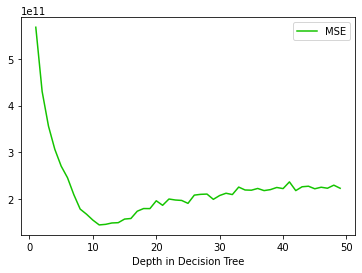

In [45]:
mse_list = list()
rmse_list = list()
x = list()
x_train, y_train, x_test, y_test = split_data(datum, 0.1)
for d in range(1, 50):
    y_predicted = Decision_Tree(x_train, y_train, x_test, 2, d)
    mse, rmse = evaluate(y_test, y_predicted)
    mse_list.append(mse/1000)
    rmse_list.append(rmse/10000)
    x.append(d)
plt.plot(x, mse_list, color='#15c400', label='MSE')
plt.xlabel('Depth in Decision Tree')
plt.legend();

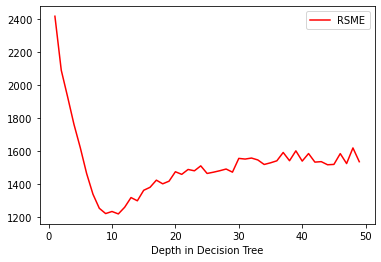

In [44]:
plt.plot(x, rmse_list, color='#ff0000', label='RSME')
plt.xlabel('Depth in Decision Tree')
plt.legend();

<div dir="rtl">
    <font size="4"><b>فاز سوم: استفاده از مدلهای تجمعی</b></font>
    <font size="3"><br></font>

In [15]:
from sklearn.ensemble import RandomForestRegressor

def Random_Forest(datum, n, b, p):
    model = RandomForestRegressor(n_estimators=n, bootstrap=b)
    x_train, y_train, x_test, y_test = split_data(datum, p)
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    return y_predicted, y_test

<div dir="rtl">
    <font size="3">7) بطور کلی در یک مدل درصورتی که مقدار bias بالا باشد به این معناست که توجه کمی به داده های آموزش شده است و اگر واریانس بالا باشد به این معناست که بیش از اندازه به داده های آموزش توجه شده است. حال در یک مدل اگر تواما bias زیاد و واریانس کم باشد underfitting رخ میدهد و اگر برعکس این حالت برقرار باشد یعنی bias کم و واریانس زیاد باشد overfitting رخ میدهد. <br>
    از آنجایی که در ادامه مشاهده میشود که خطای مدل Random Forest کمتر از خطای مدل decision tree است پس پیشبینی میشود که bias و واریانس مدل Random Forest مقدار کمتری نسبت به decision tree دارد.</font>
</div>

In [56]:
y_predicted, y_test = KNN(datum, 10, 0.1)
mse, rmse = evaluate(y_test, y_predicted)
print('KNN: MSE = %.1f RSME = %.1f' %(mse ,rmse))

KNN: MSE = 622501633359354.8 RSME = 24949982.6


In [57]:
x_train, y_train, x_test, y_test = split_data(datum, 0.1)
y_predicted = Decision_Tree(x_train, y_train, x_test, 2, 11)
mse, rmse = evaluate(y_test, y_predicted)
print('Decision Tree: MSE = %.1f RSME = %.1f' %(mse ,rmse))

Decision Tree: MSE = 148336043561966.2 RSME = 12179328.5


In [58]:
y_predicted, y_test = Linear_Regression(datum, 0.1)
mse, rmse = evaluate(y_test, y_predicted)
print('Linear Regression: MSE = %.1f RSME = %.1f' %(mse ,rmse))

Linear Regression: MSE = 386094774989740.2 RSME = 19649294.5


In [59]:
y_predicted, y_test = Random_Forest(datum, 50, True, 0.1)
mse, rmse = evaluate(y_test, y_predicted)
print('Random Forest: MSE = %.1f RSME = %.1f' %(mse ,rmse))

Random Forest: MSE = 98599717778598.4 RSME = 9929739.1
